In [1]:
from pathlib import Path
import numpy as np

from neurodsp import fourier, utils
from scipy import signal

import spikeinterface as si

import one.alf.io as alfio

from tqdm import tqdm

In [2]:
session_folder = Path('/data/ecephys_661398_2023-03-31_17-01-09')
sorting_folder = Path('/data/ecephys_661398_2023-03-31_17-01-09_sorted-ks2.5')
ecephys_compressed_folder = session_folder / 'ecephys_compressed'
sorting_curated_folder = sorting_folder / "sorting_precurated"
postprocessed_folder = sorting_folder / 'postprocessed'
ap_stream_name = 'experiment1_Record Node 104#Neuropix-PXI-100.ProbeA-AP'
lfp_stream_name = 'experiment1_Record Node 104#Neuropix-PXI-100.ProbeA-LFP'

In [3]:
RMS_WIN_LENGTH_SECS = 3
WELCH_WIN_LENGTH_SAMPLES = 1024

In [5]:
is_lfp = True

if is_lfp:
    stream_name = lfp_stream_name
else:
    stream_name = ap_stream_name

recording = si.read_zarr(ecephys_compressed_folder / f"{stream_name}.zarr")

In [6]:
recording.sampling_frequency

2500.0

In [7]:
rms_win_length_samples = 2 ** np.ceil(np.log2(recording.sampling_frequency * RMS_WIN_LENGTH_SECS))

# the window generator will generates window indices
wingen = utils.WindowGenerator(ns=recording.get_num_samples(), nswin=rms_win_length_samples, overlap=0)

In [8]:
wingen

In [9]:
win = {'TRMS': np.zeros((wingen.nwin, recording.get_num_channels())),
       'nsamples': np.zeros((wingen.nwin,)),
       'fscale': fourier.fscale(WELCH_WIN_LENGTH_SAMPLES, 1 / recording.sampling_frequency, one_sided=True),
       'tscale': wingen.tscale(fs=recording.sampling_frequency)}

win['spectral_density'] = np.zeros((len(win['fscale']), recording.get_num_channels()))

In [13]:
with tqdm(total=wingen.nwin) as pbar:
    for first, last in wingen.firstlast:
        D = recording.get_traces(start_frame=first, end_frame=last).T
        # remove low frequency noise below 1 Hz
        D = fourier.hp(D, 1 / recording.sampling_frequency, [0, 1])
        iw = wingen.iw
        win['TRMS'][iw, :] = utils.rms(D)
        win['nsamples'][iw] = D.shape[1]
        if is_lfp:
            # the last window may be smaller than what is needed for welch
            if last - first < WELCH_WIN_LENGTH_SAMPLES:
                continue
            # compute a smoothed spectrum using welch method
            _, w = signal.welch(
                D, fs=recording.sampling_frequency, window='hann', nperseg=WELCH_WIN_LENGTH_SAMPLES,
                detrend='constant', return_onesided=True, scaling='density', axis=-1
            )
            win['spectral_density'] += w.T
        # print at least every 20 windows
        if (iw % min(20, max(int(np.floor(wingen.nwin / 75)), 1))) == 0:
            pbar.update(iw)
            break

  0%|          | 0/1912 [00:01<?, ?it/s]


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
win['TRMS'].shape

(1912, 384)

In [20]:
win['spectral_density']

array([[8.62762922e-02, 7.11876453e-02, 1.06595478e-01, ...,
        5.19098946e+00, 4.68620116e+00, 4.56061024e+00],
       [2.75416936e-01, 4.46555814e-01, 5.02911647e-01, ...,
        2.13657580e+01, 2.07657428e+01, 2.27513932e+01],
       [1.50623046e-01, 1.81201594e-01, 2.50064894e-01, ...,
        1.66013453e+01, 1.60617233e+01, 1.67327905e+01],
       ...,
       [9.75978262e-04, 1.46892988e-03, 2.40603120e-03, ...,
        5.00695778e-04, 3.53746124e-04, 4.94532921e-04],
       [1.32014479e-03, 1.70729702e-03, 2.62640640e-03, ...,
        5.16154882e-04, 4.04750716e-04, 4.04899076e-04],
       [8.53241942e-04, 9.06927108e-04, 1.17211584e-03, ...,
        2.60385807e-04, 2.13660542e-04, 2.68476732e-04]])

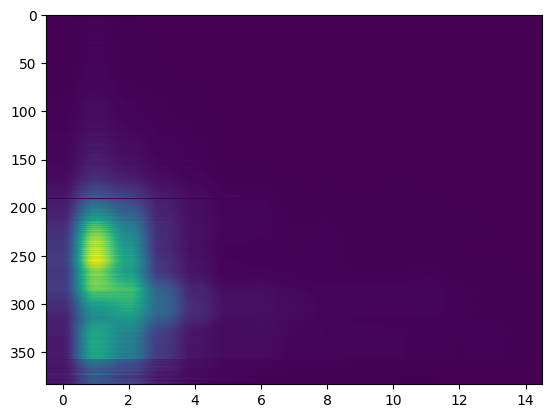

In [16]:
plt.imshow(win['spectral_density'][:15].T, aspect='auto')

In [17]:
win['spectral_density'].shape

(513, 384)

In [69]:
out_path = Path('/results/')

alf_object_time = f'ephysTimeRmsLFP'
alf_object_freq = f'ephysSpectralDensityLFP'

tdict = {'rms': win['TRMS'].astype(np.single), 'timestamps': win['tscale'].astype(np.single)}
alfio.save_object_npy(out_path, object=alf_object_time, dico=tdict, namespace='iblqc')
if spectra:
    fdict = {'power': win['spectral_density'].astype(np.single),
             'freqs': win['fscale'].astype(np.single)}
    alfio.save_object_npy(
        out_path, object=alf_object_freq, dico=fdict, namespace='iblqc')

### Try to extract the spikes

In [ ]:
ks2_to_alf(ks_path, 
           ephys_path, 
           out_path, 
           bin_file=efile.ap,
           ampfactor=_sample2v(efile.ap), 
           label=None, 
           force=True)

In [ ]:
m = ephysqc.phy_model_from_ks2_path(ks2_path=ks_path, 
                                    bin_path=bin_path, 
                                    bin_file=bin_file)

ac = alf.EphysAlfCreator(m)
ac.convert(out_path, label=label, force=force, ampfactor=ampfactor)

In [ ]:
recording = si.read_zarr(ecephys_compressed_folder / f"{ap_stream_name}.zarr")

fs = recording.sampling_frequency
nch = recording.get_num_channels()

In [ ]:
NCH_WAVEFORMS = 32  # number of channels to be saved in templates.waveforms and channels.waveforms

m = model.TemplateModel(dir_path=ks2_path,
                        dat_path=bin_file,  # this assumes the raw data is in the same folder
                        sample_rate=fs,
                        n_channels_dat=nch,
                        n_closest_channels=NCH_WAVEFORMS)

m.depths = m.get_depths()

In [3]:
recording = si.read_zarr(ecephys_compressed_folder / f"{ap_stream_name}.zarr")

recording_folder_name = f'{ap_stream_name}_recording1'

sorting_precurated = si.load_extractor(sorting_curated_folder / recording_folder_name)

we = si.WaveformExtractor.load_from_folder(postprocessed_folder / f'{ap_stream_name}_recording1',
                               sorting=sorting_precurated, 
                               with_recording=False)

we.set_recording(recording)

/opt/conda/lib/python3.9/site-packages/spikeinterface/core/base.py:998: UserWarning: Versions are not the same. This might lead compatibility errors. Using spikeinterface==0.97.1 is recommended
  warnings.warn(


ValueError: Couldn't set the WaveformExtractor recording: channel_ids do not match!
['AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7', 'AP8', 'AP9', 'AP10', 'AP11', 'AP12', 'AP13', 'AP14', 'AP15', 'AP16', 'AP17', 'AP18', 'AP19', 'AP20', 'AP21', 'AP22', 'AP23', 'AP24', 'AP25', 'AP26', 'AP27', 'AP28', 'AP29', 'AP30', 'AP31', 'AP32', 'AP33', 'AP34', 'AP35', 'AP36', 'AP37', 'AP38', 'AP39', 'AP40', 'AP41', 'AP42', 'AP43', 'AP44', 'AP45', 'AP46', 'AP47', 'AP48', 'AP49', 'AP50', 'AP51', 'AP52', 'AP53', 'AP54', 'AP55', 'AP56', 'AP57', 'AP58', 'AP59', 'AP60', 'AP61', 'AP62', 'AP63', 'AP64', 'AP65', 'AP66', 'AP67', 'AP68', 'AP69', 'AP70', 'AP71', 'AP72', 'AP73', 'AP74', 'AP75', 'AP76', 'AP77', 'AP78', 'AP79', 'AP80', 'AP81', 'AP82', 'AP83', 'AP84', 'AP85', 'AP86', 'AP87', 'AP88', 'AP89', 'AP90', 'AP91', 'AP92', 'AP93', 'AP94', 'AP95', 'AP96', 'AP97', 'AP98', 'AP99', 'AP100', 'AP101', 'AP102', 'AP103', 'AP104', 'AP105', 'AP106', 'AP107', 'AP108', 'AP109', 'AP110', 'AP111', 'AP112', 'AP113', 'AP114', 'AP115', 'AP116', 'AP117', 'AP118', 'AP119', 'AP120', 'AP121', 'AP122', 'AP123', 'AP124', 'AP125', 'AP126', 'AP127', 'AP128', 'AP129', 'AP130', 'AP131', 'AP132', 'AP133', 'AP134', 'AP135', 'AP136', 'AP137', 'AP138', 'AP139', 'AP140', 'AP141', 'AP142', 'AP143', 'AP144', 'AP145', 'AP146', 'AP147', 'AP148', 'AP149', 'AP150', 'AP151', 'AP152', 'AP153', 'AP154', 'AP155', 'AP156', 'AP157', 'AP158', 'AP159', 'AP160', 'AP161', 'AP162', 'AP163', 'AP164', 'AP165', 'AP166', 'AP167', 'AP168', 'AP169', 'AP170', 'AP171', 'AP172', 'AP173', 'AP174', 'AP175', 'AP176', 'AP177', 'AP178', 'AP179', 'AP180', 'AP181', 'AP182', 'AP183', 'AP184', 'AP185', 'AP186', 'AP187', 'AP188', 'AP189', 'AP190', 'AP191', 'AP193', 'AP194', 'AP195', 'AP196', 'AP197', 'AP198', 'AP199', 'AP200', 'AP201', 'AP202', 'AP203', 'AP204', 'AP205', 'AP206', 'AP207', 'AP208', 'AP209', 'AP210', 'AP211', 'AP212', 'AP213', 'AP214', 'AP215', 'AP216', 'AP217', 'AP218', 'AP219', 'AP220', 'AP221', 'AP222', 'AP223', 'AP224', 'AP225', 'AP226', 'AP227', 'AP228', 'AP229', 'AP230', 'AP231', 'AP232', 'AP233', 'AP234', 'AP235', 'AP236', 'AP237', 'AP238', 'AP239', 'AP240', 'AP241', 'AP242', 'AP243', 'AP244', 'AP245', 'AP246', 'AP247', 'AP248', 'AP249', 'AP250', 'AP251', 'AP252', 'AP253', 'AP254', 'AP255', 'AP256', 'AP257', 'AP258', 'AP259', 'AP260', 'AP261', 'AP262', 'AP263', 'AP264', 'AP265', 'AP266', 'AP267', 'AP268', 'AP269', 'AP270', 'AP271', 'AP272', 'AP273', 'AP274', 'AP275', 'AP276', 'AP277', 'AP278', 'AP279', 'AP280', 'AP281', 'AP282', 'AP283', 'AP284', 'AP285', 'AP286', 'AP287', 'AP288', 'AP289', 'AP290', 'AP291', 'AP292', 'AP293', 'AP294', 'AP295', 'AP296', 'AP297', 'AP298', 'AP299', 'AP300', 'AP301', 'AP302', 'AP303', 'AP304', 'AP305', 'AP306', 'AP307', 'AP308', 'AP309', 'AP310', 'AP311', 'AP312', 'AP313', 'AP314', 'AP315', 'AP316', 'AP317', 'AP318', 'AP319', 'AP320', 'AP321', 'AP322', 'AP323', 'AP324', 'AP325', 'AP326', 'AP327', 'AP328', 'AP329', 'AP330', 'AP331', 'AP332', 'AP333', 'AP334', 'AP335', 'AP336', 'AP337', 'AP338', 'AP339', 'AP340', 'AP341', 'AP342', 'AP343', 'AP344', 'AP345', 'AP346', 'AP347', 'AP348', 'AP349', 'AP350', 'AP351', 'AP352', 'AP353', 'AP354', 'AP355', 'AP356', 'AP357', 'AP358', 'AP359']

In [7]:
we.channel_ids

array(['AP1', 'AP2', 'AP3', 'AP4', 'AP5', 'AP6', 'AP7', 'AP8', 'AP9',
       'AP10', 'AP11', 'AP12', 'AP13', 'AP14', 'AP15', 'AP16', 'AP17',
       'AP18', 'AP19', 'AP20', 'AP21', 'AP22', 'AP23', 'AP24', 'AP25',
       'AP26', 'AP27', 'AP28', 'AP29', 'AP30', 'AP31', 'AP32', 'AP33',
       'AP34', 'AP35', 'AP36', 'AP37', 'AP38', 'AP39', 'AP40', 'AP41',
       'AP42', 'AP43', 'AP44', 'AP45', 'AP46', 'AP47', 'AP48', 'AP49',
       'AP50', 'AP51', 'AP52', 'AP53', 'AP54', 'AP55', 'AP56', 'AP57',
       'AP58', 'AP59', 'AP60', 'AP61', 'AP62', 'AP63', 'AP64', 'AP65',
       'AP66', 'AP67', 'AP68', 'AP69', 'AP70', 'AP71', 'AP72', 'AP73',
       'AP74', 'AP75', 'AP76', 'AP77', 'AP78', 'AP79', 'AP80', 'AP81',
       'AP82', 'AP83', 'AP84', 'AP85', 'AP86', 'AP87', 'AP88', 'AP89',
       'AP90', 'AP91', 'AP92', 'AP93', 'AP94', 'AP95', 'AP96', 'AP97',
       'AP98', 'AP99', 'AP100', 'AP101', 'AP102', 'AP103', 'AP104',
       'AP105', 'AP106', 'AP107', 'AP108', 'AP109', 'AP110', 'AP111',
       'AP1

In [ ]:
from spikeinterface.preprocessing import 

In [ ]:
recording.s

In [21]:
from spikeinterface.exporters import export_to_phy

In [22]:
export_to_phy(we, output_folder='/results/phy')

ValueError: WaveformExtractor is used in mode "with_recording=False" this operation needs the recording

In [18]:
si.__version__

'0.96.0'

In [20]:
exp = si.exporters

AttributeError: module 'spikeinterface' has no attribute 'exporters'